# 2. Modelo de Regresión Lineal - Pronóstico de Demanda Eléctrica

Este notebook implementa un modelo de **Regresión Lineal** para predecir el consumo eléctrico horario de la región PJM East.

## Objetivo:
Construir un modelo baseline de regresión lineal que servirá como punto de comparación para modelos más complejos.

## Contenido:
1. **Carga y Preparación de Datos**
2. **Ingeniería de Características (Feature Engineering)**
3. **División de Datos** - Train/Test cronológico
4. **Entrenamiento del Modelo**
5. **Evaluación del Modelo** - MAE, RMSE, R²
6. **Análisis de Resultados**

---
## 1. Carga y Preparación de Datos

In [38]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

print("Librerías utilizadas:")
print("   • pandas: Manipulación de datos")
print("   • numpy: Operaciones numéricas")
print("   • matplotlib/seaborn: Visualización")
print("   • sklearn: Machine Learning")

Librerías utilizadas:
   • pandas: Manipulación de datos
   • numpy: Operaciones numéricas
   • matplotlib/seaborn: Visualización
   • sklearn: Machine Learning


In [39]:
# Cargar el dataset
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'])

# Ordenar por fecha y establecer como índice
df = df.sort_values('Datetime').reset_index(drop=True)
df.set_index('Datetime', inplace=True)

print(f"Información del Dataset:\n")
print(f"   • Registros: {len(df):,}")
print(f"   • Período: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"   • Duración: {(df.index.max() - df.index.min()).days / 365:.1f} años")
print(f"   • Frecuencia: Horaria (1 registro por hora)")
print(f"\nEstadísticas del consumo (PJME_MW):\n")
print(f"   • Promedio: {df['PJME_MW'].mean():,.0f} MW")
print(f"   • Desv. Estándar: {df['PJME_MW'].std():,.0f} MW")
print(f"   • Mínimo: {df['PJME_MW'].min():,.0f} MW")
print(f"   • Máximo: {df['PJME_MW'].max():,.0f} MW")

Información del Dataset:

   • Registros: 145,366
   • Período: 2002-01-01 a 2018-08-03
   • Duración: 16.6 años
   • Frecuencia: Horaria (1 registro por hora)

Estadísticas del consumo (PJME_MW):

   • Promedio: 32,080 MW
   • Desv. Estándar: 6,464 MW
   • Mínimo: 14,544 MW
   • Máximo: 62,009 MW


In [40]:
# Vista rápida de los datos
print("📋 Vista previa del dataset:")
df.head(10)

📋 Vista previa del dataset:


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0


---
## 2. Ingeniería de Características (Feature Engineering)

Feature Engineering es el proceso de crear nuevas variables (features) a partir de los datos existentes que ayuden al modelo a hacer mejores predicciones.

### Características que crearemos:

| Tipo | Variable | Descripción | Justificación |
|------|----------|-------------|---------------|
| **Temporal** | hour | Hora del día (0-23) | El consumo varía según la hora |
| **Temporal** | dayofweek | Día de la semana (0-6) | Diferencia entre laborables/fin de semana |
| **Temporal** | month | Mes del año (1-12) | Estacionalidad climática |
| **Temporal** | quarter | Trimestre (1-4) | Patrones estacionales agregados |
| **Temporal** | year | Año | Tendencia a largo plazo |
| **Temporal** | dayofyear | Día del año (1-366) | Posición en el ciclo anual |
| **Lag** | lag_1 | Consumo hace 1 hora | Autocorrelación inmediata |
| **Lag** | lag_24 | Consumo hace 24 horas | Patrón del día anterior |

Las variables **lag** (retraso) capturan la **autocorrelación** de la serie temporal:
- **lag_1**: El consumo de la hora actual está muy relacionado con la hora anterior
- **lag_24**: El consumo tiende a repetirse en el mismo horario del día anterior

In [41]:
def create_features(df):
    df = df.copy()
    
    # Características temporales
    df['hour'] = df.index.hour           # Hora del día (0-23)
    df['dayofweek'] = df.index.dayofweek # Día de la semana (0=Lun, 6=Dom)
    df['quarter'] = df.index.quarter     # Trimestre (1-4)
    df['month'] = df.index.month         # Mes (1-12)
    df['year'] = df.index.year           # Año
    df['dayofyear'] = df.index.dayofyear # Día del año (1-366)
    
    # Variables de retraso (lags) - Capturan autocorrelación
    df['lag_1'] = df['PJME_MW'].shift(1)   # Consumo hace 1 hora
    df['lag_24'] = df['PJME_MW'].shift(24) # Consumo hace 24 horas
    
    return df

# Aplicar la función
df = create_features(df)

In [56]:
# Verificar y manejar valores nulos
print("MANEJO DE VALORES NULOS")
print("\nValores nulos por columna (antes de limpiar):")
print(df.isnull().sum())

# Eliminar filas con valores nulos (causados por los lags)
filas_antes = len(df)
df = df.dropna()
filas_eliminadas = filas_antes - len(df)

print(f"Filas eliminadas: {filas_eliminadas} (primeras {filas_eliminadas} horas por los lags)")
print(f"Filas restantes: {len(df):,}")

MANEJO DE VALORES NULOS

Valores nulos por columna (antes de limpiar):
PJME_MW      0
hour         0
dayofweek    0
quarter      0
month        0
year         0
dayofyear    0
lag_1        0
lag_24       0
dtype: int64
Filas eliminadas: 0 (primeras 0 horas por los lags)
Filas restantes: 145,342


In [57]:
# Vista del DataFrame con características
print("Vista del DataFrame con características creadas:")
df.head(10)

Vista del DataFrame con características creadas:


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag_1,lag_24
Datetime,,,,,,,,,
2002-01-02 01:00:00,28121.0,1,2,1,1,2002,2,29563.0,30393.0
2002-01-02 02:00:00,27437.0,2,2,1,1,2002,2,28121.0,29265.0
2002-01-02 03:00:00,27301.0,3,2,1,1,2002,2,27437.0,28357.0
2002-01-02 04:00:00,27533.0,4,2,1,1,2002,2,27301.0,27899.0
2002-01-02 05:00:00,28405.0,5,2,1,1,2002,2,27533.0,28057.0
2002-01-02 06:00:00,30748.0,6,2,1,1,2002,2,28405.0,28654.0
2002-01-02 07:00:00,34725.0,7,2,1,1,2002,2,30748.0,29308.0
2002-01-02 08:00:00,37313.0,8,2,1,1,2002,2,34725.0,29595.0
2002-01-02 09:00:00,37322.0,9,2,1,1,2002,2,37313.0,29943.0


---
## 3. División de Datos: Entrenamiento y Test

### Estrategia de División Cronológica

En series temporales, no se puede usar división aleatoria porque:
- Los datos futuros no pueden usarse para predecir el pasado
- Necesitamos simular un escenario real de predicción

### Nuestra División:

```
    2002 ────────────────────────── 2017 ────────── 2018
    ├──────── ENTRENAMIENTO ────────┤──── TEST ────┤
    │         (~85% datos)          │   (~15%)     │
```

- **Entrenamiento**: Datos anteriores al 01-01-2017
- **Test**: Datos desde el 01-01-2017 en adelante

Esto simula un escenario real donde entrenamos con datos históricos y evaluamos con datos "futuros".

In [58]:
# Definir la fecha de corte
FECHA_CORTE = '2017-01-01'

# División cronológica
train = df.loc[df.index < FECHA_CORTE].copy()
test = df.loc[df.index >= FECHA_CORTE].copy()

print("DIVISIÓN DE DATOS")
print(f"\nFecha de corte: {FECHA_CORTE}")
print(f"\nENTRENAMIENTO (Train):")
print(f"   • Registros: {len(train):,}")
print(f"   • Período: {train.index.min().strftime('%Y-%m-%d')} a {train.index.max().strftime('%Y-%m-%d')}")
print(f"   • Porcentaje: {len(train)/len(df)*100:.1f}%")
print(f"\nTEST:")
print(f"   • Registros: {len(test):,}")
print(f"   • Período: {test.index.min().strftime('%Y-%m-%d')} a {test.index.max().strftime('%Y-%m-%d')}")
print(f"   • Porcentaje: {len(test)/len(df)*100:.1f}%")

DIVISIÓN DE DATOS

Fecha de corte: 2017-01-01

ENTRENAMIENTO (Train):
   • Registros: 131,446
   • Período: 2002-01-02 a 2016-12-31
   • Porcentaje: 90.4%

TEST:
   • Registros: 13,896
   • Período: 2017-01-01 a 2018-08-03
   • Porcentaje: 9.6%


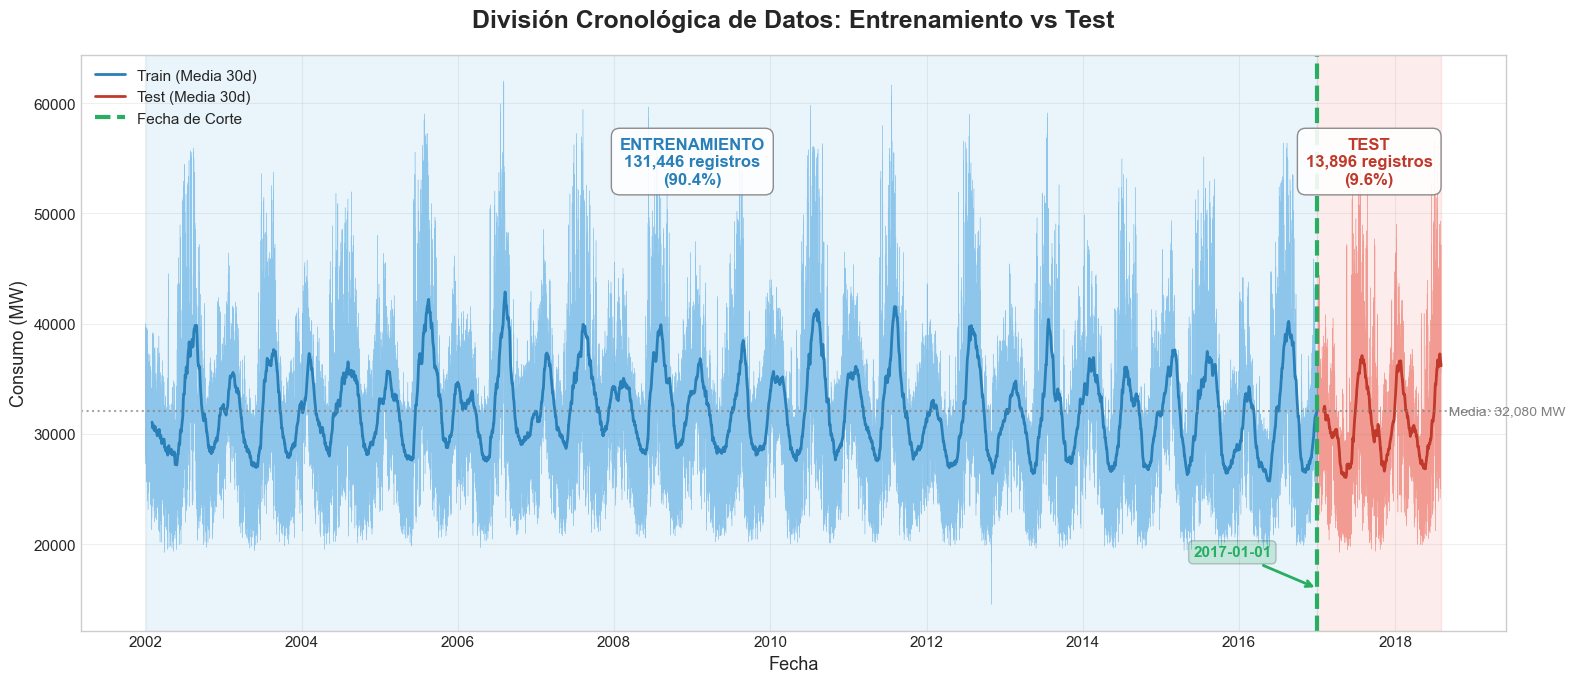

In [60]:
# Visualizar la división de datos
fig, ax = plt.subplots(figsize=(16, 7))

# Plotear datos con mejor visibilidad
ax.plot(train.index, train['PJME_MW'], color='#3498db', alpha=0.5, linewidth=0.3)
ax.plot(test.index, test['PJME_MW'], color='#e74c3c', alpha=0.5, linewidth=0.3)

# Añadir medias móviles
train_ma = train['PJME_MW'].rolling(window=24*30).mean()
test_ma = test['PJME_MW'].rolling(window=24*30).mean()
ax.plot(train.index, train_ma, color='#2980b9', linewidth=2, label='Train (Media 30d)')
ax.plot(test.index, test_ma, color='#c0392b', linewidth=2, label='Test (Media 30d)')

# Línea de corte más visible
ax.axvline(x=pd.Timestamp(FECHA_CORTE), color='#27ae60', linestyle='--', linewidth=3, 
           label=f'Fecha de Corte')

# Sombrear regiones
ax.axvspan(train.index.min(), pd.Timestamp(FECHA_CORTE), alpha=0.1, color='#3498db')
ax.axvspan(pd.Timestamp(FECHA_CORTE), test.index.max(), alpha=0.1, color='#e74c3c')

# Configuración del gráfico
ax.set_title('División Cronológica de Datos: Entrenamiento vs Test', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Consumo (MW)', fontsize=13)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Anotaciones con cajas
bbox_props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.9)

ax.annotate(f'ENTRENAMIENTO\n{len(train):,} registros\n({len(train)/len(df)*100:.1f}%)', 
            xy=(pd.Timestamp('2009-01-01'), df['PJME_MW'].max()*0.85),
            fontsize=12, color='#2980b9', fontweight='bold', ha='center',
            bbox=bbox_props)

ax.annotate(f'TEST\n{len(test):,} registros\n({len(test)/len(df)*100:.1f}%)', 
            xy=(pd.Timestamp('2017-09-01'), df['PJME_MW'].max()*0.85),
            fontsize=12, color='#c0392b', fontweight='bold', ha='center',
            bbox=bbox_props)

# Anotación de la fecha de corte
ax.annotate(f'{FECHA_CORTE}', 
            xy=(pd.Timestamp(FECHA_CORTE), df['PJME_MW'].min()*1.1),
            xytext=(pd.Timestamp('2015-06-01'), df['PJME_MW'].min()*1.3),
            fontsize=11, fontweight='bold', color='#27ae60',
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2),
            bbox=dict(boxstyle='round', facecolor='#27ae60', alpha=0.2))

# Formato del eje X
ax.tick_params(axis='both', labelsize=11)

# Líneas horizontales de referencia
media_total = df['PJME_MW'].mean()
ax.axhline(y=media_total, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.text(df.index.max(), media_total, f'  Media: {media_total:,.0f} MW', 
        va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

---
## 4. Definición de Variables y Entrenamiento del Modelo

### Variables del Modelo

- **Variable Objetivo (y)**: `PJME_MW` - Consumo eléctrico en megawatts
- **Variables Predictoras (X)**: Características temporales y lags

### Proceso de Entrenamiento

1. Separar X (features) e y (target)
2. Crear instancia del modelo `LinearRegression()`
3. Ajustar el modelo con datos de entrenamiento usando `.fit()`
4. El modelo calcula los coeficientes óptimos (β)

In [61]:
# Definir características y objetivo
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1', 'lag_24']
TARGET = 'PJME_MW'

# Separar X e y
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print("DEFINICIÓN DE VARIABLES")
print(f"\nVariable Objetivo (y): {TARGET}")
print(f"\nCaracterísticas (X):")
for i, feat in enumerate(FEATURES, 1):
    print(f"   {i}. {feat}")
print(f"\nDimensiones:")
print(f"   • X_train: {X_train.shape} → {X_train.shape[0]:,} filas × {X_train.shape[1]} características")
print(f"   • y_train: {y_train.shape}")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")

DEFINICIÓN DE VARIABLES

Variable Objetivo (y): PJME_MW

Características (X):
   1. hour
   2. dayofweek
   3. quarter
   4. month
   5. year
   6. dayofyear
   7. lag_1
   8. lag_24

Dimensiones:
   • X_train: (131446, 8) → 131,446 filas × 8 características
   • y_train: (131446,)
   • X_test: (13896, 8)
   • y_test: (13896,)


In [62]:
# Crear y entrenar el modelo
modelo_lr = LinearRegression()

# Entrenar (fit) el modelo
modelo_lr.fit(X_train, y_train)

print(f"Ecuación del Modelo:")
print(f"   y = {modelo_lr.intercept_:.2f}", end="")
for feat, coef in zip(FEATURES, modelo_lr.coef_):
    signo = "+" if coef >= 0 else ""
    print(f" {signo}{coef:.4f}×{feat}", end="")
print("\n")

Ecuación del Modelo:
   y = 1958.77 +4.0436×hour -160.6006×dayofweek +30.5238×quarter -1.9813×month -0.6045×year -0.3039×dayofyear +0.7775×lag_1 +0.2127×lag_24



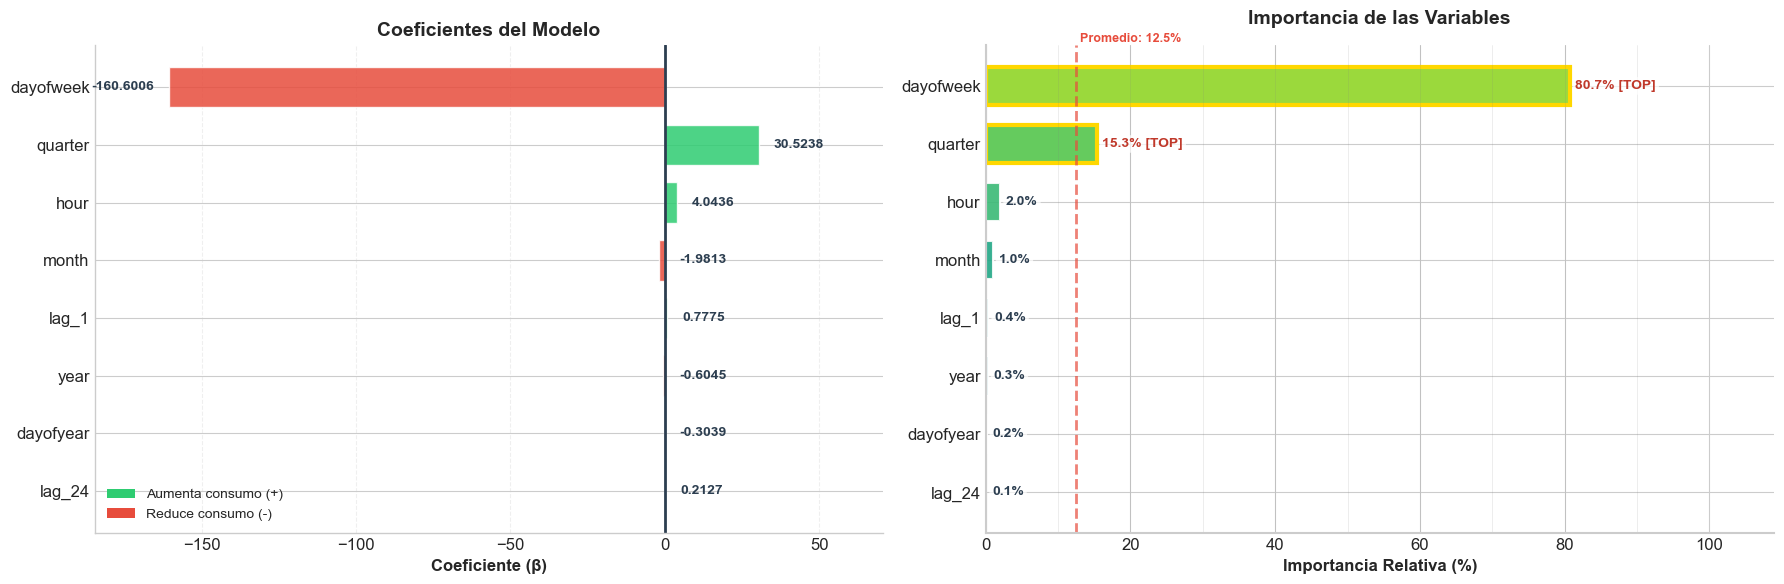

In [89]:
# Visualizar los coeficientes del modelo
coef_df = pd.DataFrame({
    'Feature': FEATURES,
    'Coeficiente': modelo_lr.coef_,
    'Coef_Abs': np.abs(modelo_lr.coef_)
}).sort_values('Coef_Abs', ascending=True)

# Calcular la importancia relativa (%)
coef_df['Importancia_Rel'] = (coef_df['Coef_Abs'] / coef_df['Coef_Abs'].sum()) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Coeficientes con valores
ax1 = axes[0]

# Colores según signo
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_df['Coeficiente']]
bars = ax1.barh(coef_df['Feature'], coef_df['Coeficiente'], color=colors, 
                edgecolor='white', height=0.7, alpha=0.85)

# Línea vertical en cero
ax1.axvline(x=0, color='#2c3e50', linewidth=2)

# Configuración
ax1.set_xlabel('Coeficiente (β)', fontsize=12, fontweight='bold')
ax1.set_ylabel('')
ax1.set_title('Coeficientes del Modelo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir valores en las barras
max_coef = coef_df['Coef_Abs'].max()
offset = 0.03 * max_coef

for bar, val in zip(bars, coef_df['Coeficiente']):
    if val >= 0:
        x_pos = val + offset
        ha = 'left'
    elif abs(val) < (0.15 * max_coef):
        x_pos = offset
        ha = 'left'
    else:
        x_pos = val - offset
        ha = 'right'
    
    ax1.text(x_pos, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', ha=ha, fontsize=10, fontweight='bold',
             color='#2c3e50')

x_min = coef_df['Coeficiente'].min()
x_max = coef_df['Coeficiente'].max()
ax1.set_xlim(x_min - (0.15 * max_coef), x_max + (0.25 * max_coef))

# Leyenda de colores
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Aumenta consumo (+)'),
                   Patch(facecolor='#e74c3c', label='Reduce consumo (-)')]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=10, framealpha=0.9)

# Gráfico 2: Importancia Relativa
ax2 = axes[1]

coef_sorted = coef_df.sort_values('Importancia_Rel', ascending=True)

# Gradiente de colores
n_bars = len(coef_sorted)
colors_importance = plt.cm.viridis(np.linspace(0.25, 0.85, n_bars))

# Barras
bars2 = ax2.barh(coef_sorted['Feature'], coef_sorted['Importancia_Rel'], 
                 color=colors_importance, edgecolor='white', height=0.65,
                 linewidth=1.5, alpha=0.9)

# Líneas de referencia sutiles
for i in range(0, int(coef_sorted['Importancia_Rel'].max()) + 15, 10):
    ax2.axvline(x=i, color='gray', linestyle='-', linewidth=0.5, alpha=0.2)

# Configuración de ejes
ax2.set_xlabel('Importancia Relativa (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Importancia de las Variables', fontsize=14, fontweight='bold', pad=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

# Destacar las 2 variables más importantes
top_2_features = coef_sorted.nlargest(2, 'Importancia_Rel')['Feature'].tolist()
for bar, feat in zip(bars2, coef_sorted['Feature']):
    if feat in top_2_features:
        bar.set_edgecolor('#FFD700')
        bar.set_linewidth(3)
        bar.set_alpha(1.0)

# Añadir valores con indicador [TOP] para las más importantes
for bar, (idx, row) in zip(bars2, coef_sorted.iterrows()):
    val = row['Importancia_Rel']
    feat = row['Feature']
    
    # Indicador para las top 2
    suffix = ' [TOP]' if feat in top_2_features else ''
    
    ax2.text(val + 0.8, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%{suffix}', va='center', ha='left', fontsize=10, fontweight='bold',
             color='#c0392b' if feat in top_2_features else '#2c3e50',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7))

# Línea de promedio
avg_importance = coef_sorted['Importancia_Rel'].mean()
ax2.axvline(x=avg_importance, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(avg_importance + 0.5, n_bars - 0.3, f'Promedio: {avg_importance:.1f}%', 
         fontsize=9, color='#e74c3c', fontweight='bold', va='bottom')

# Ajustar límites
ax2.set_xlim(0, coef_sorted['Importancia_Rel'].max() * 1.35)

plt.tight_layout()
plt.show()

In [73]:
# Interpretación detallada
print("Interpretación de coeficientes")
print("   Por cada unidad que aumenta la variable, el consumo cambia en β MW")

print("\nTop 3 variables más influyentes:")
top_3 = coef_df.nlargest(3, 'Coef_Abs')
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    signo = "↑" if row['Coeficiente'] > 0 else "↓"
    print(f"   {i}. {row['Feature']}: {row['Coeficiente']:+.4f} ({row['Importancia_Rel']:.1f}%) {signo}")

print("\nInterpretación por tipo de variable:")
print("   LAGs (lag_1, lag_24): Alta autocorrelación - el consumo pasado predice el futuro")
print("   Temporales: Capturan patrones estacionales (hora, día, mes)")

positivas = coef_df[coef_df['Coeficiente'] > 0]['Feature'].tolist()
negativas = coef_df[coef_df['Coeficiente'] < 0]['Feature'].tolist()

print(f"\nVariables que AUMENTAN el consumo ({len(positivas)}): {', '.join(positivas)}")
print(f"Variables que REDUCEN el consumo ({len(negativas)}): {', '.join(negativas)}")

Interpretación de coeficientes
   Por cada unidad que aumenta la variable, el consumo cambia en β MW

Top 3 variables más influyentes:
   1. dayofweek: -160.6006 (80.7%) ↓
   2. quarter: +30.5238 (15.3%) ↑
   3. hour: +4.0436 (2.0%) ↑

Interpretación por tipo de variable:
   LAGs (lag_1, lag_24): Alta autocorrelación - el consumo pasado predice el futuro
   Temporales: Capturan patrones estacionales (hora, día, mes)

Variables que AUMENTAN el consumo (4): lag_24, lag_1, hour, quarter
Variables que REDUCEN el consumo (4): dayofyear, year, month, dayofweek


---
### 5. Evaluación del Modelo

### Métricas de Evaluación

| Métrica | Fórmula | Interpretación |
|---------|---------|----------------|
| **MAE** | Mean Absolute Error | Error promedio en MW. Fácil de interpretar |
| **RMSE** | Root Mean Square Error | Penaliza errores grandes. Misma unidad que y |
| **R²** | Coeficiente de Determinación | % de varianza explicada (0-1). Cercano a 1 es mejor |
| **MAPE** | Mean Absolute Percentage Error | Error porcentual promedio |

### Fórmulas:

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

In [77]:
# Realizar predicciones
y_pred = modelo_lr.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Métricas de Evaluación")
print(f"\nMAE (Mean Absolute Error): {mae:,.2f} MW")
print(f"   → En promedio, el modelo se equivoca por ±{mae:,.0f} MW")
print(f"\nRMSE (Root Mean Squared Error): {rmse:,.2f} MW")
print(f"   → Penaliza más los errores grandes")
print(f"\nR² (Coeficiente de Determinación): {r2:.4f}")
print(f"   → El modelo explica el {r2*100:.2f}% de la varianza")
print(f"\nMAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"   → Error porcentual promedio")
print(f"\nContexto:")
print(f"   • Consumo promedio en test: {y_test.mean():,.0f} MW")
print(f"   • Error relativo (MAE/Media): {(mae/y_test.mean())*100:.2f}%")

Métricas de Evaluación

MAE (Mean Absolute Error): 976.56 MW
   → En promedio, el modelo se equivoca por ±977 MW

RMSE (Root Mean Squared Error): 1,250.44 MW
   → Penaliza más los errores grandes

R² (Coeficiente de Determinación): 0.9583
   → El modelo explica el 95.83% de la varianza

MAPE (Mean Absolute Percentage Error): 3.15%
   → Error porcentual promedio

Contexto:
   • Consumo promedio en test: 31,069 MW
   • Error relativo (MAE/Media): 3.14%


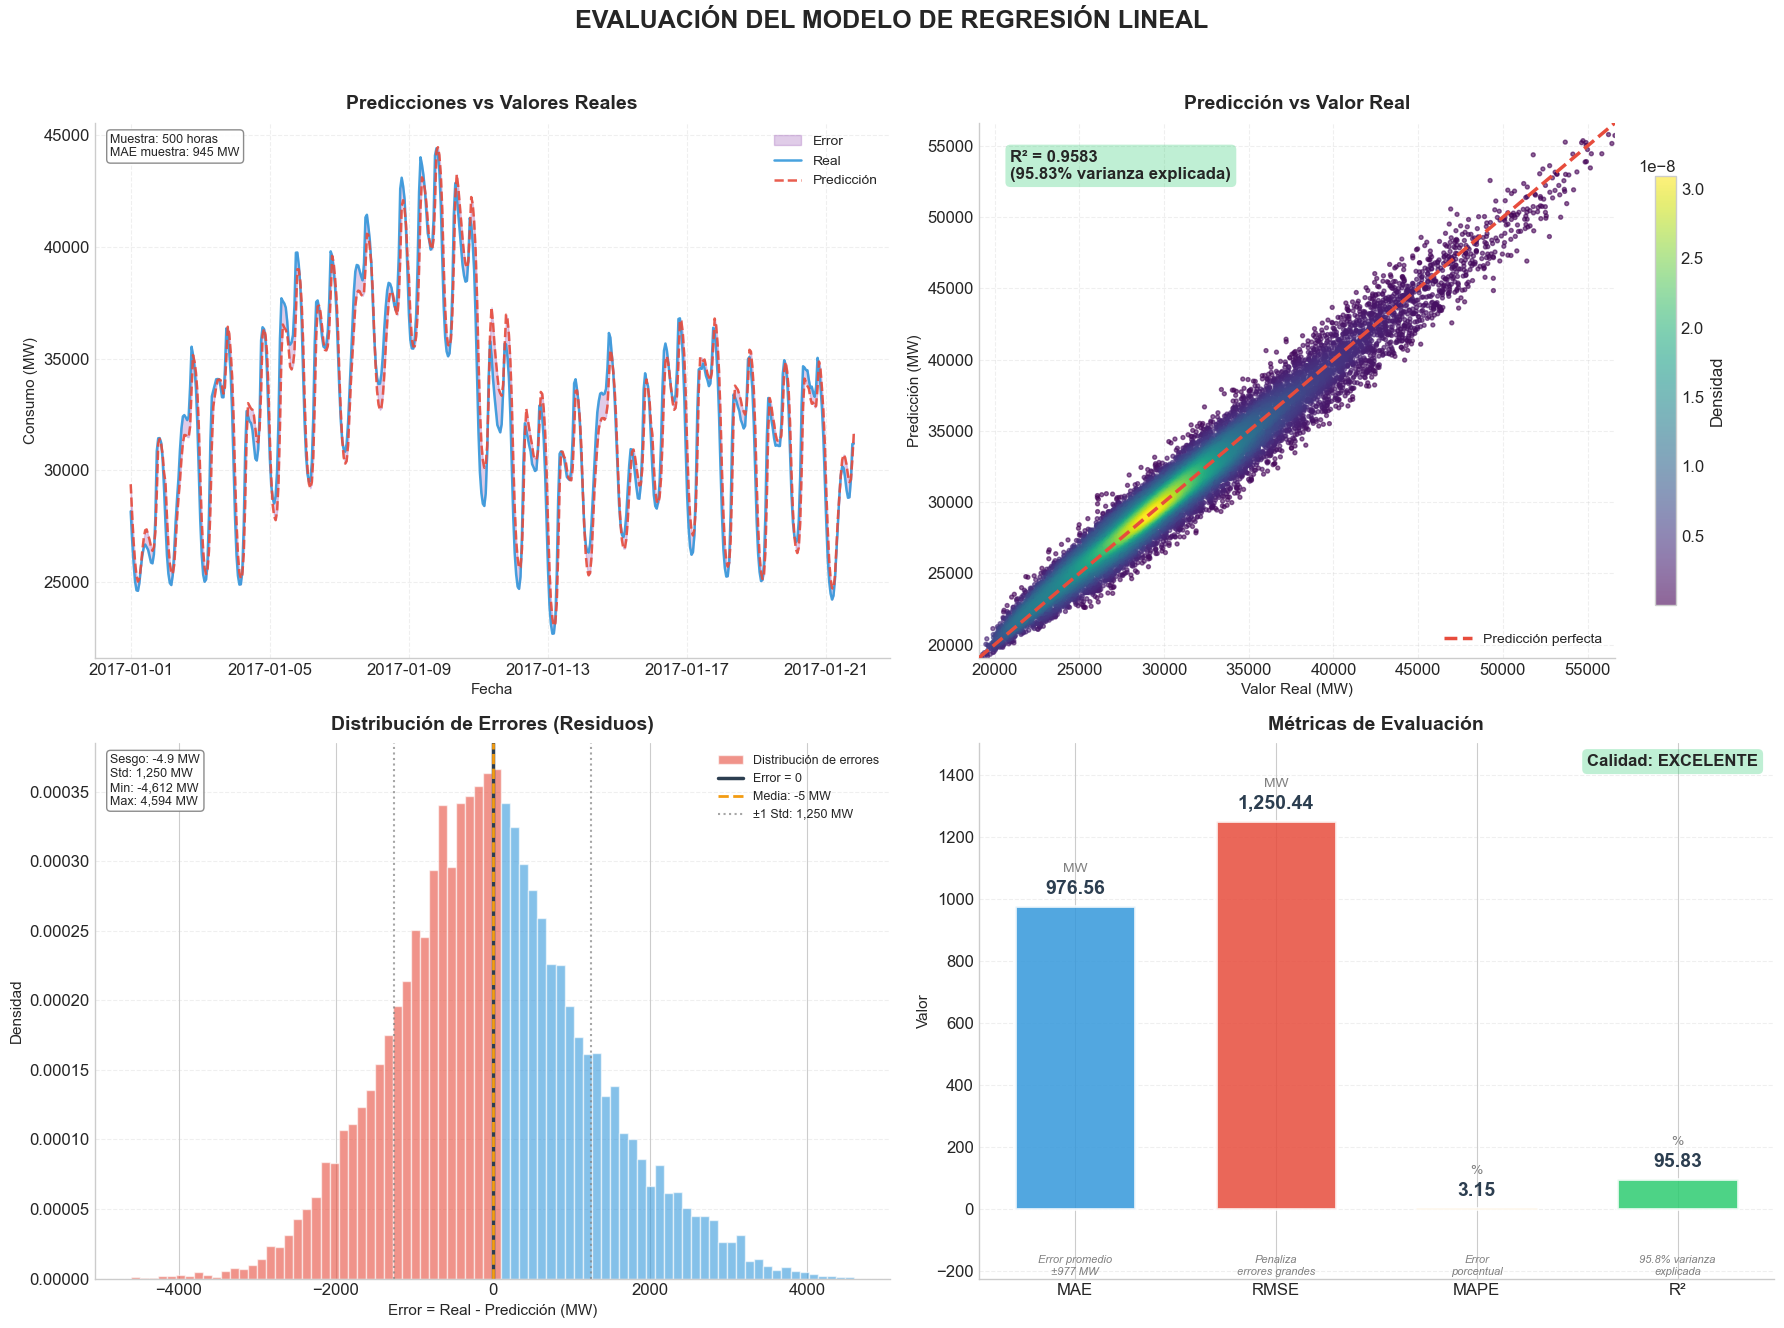

In [ ]:
# Visualización completa de resultados
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle('EVALUACIÓN DEL MODELO DE REGRESIÓN LINEAL', fontsize=18, fontweight='bold', y=1.02)

# Gráfico1: Serie temporal - Predicciones vs Reales
ax1 = axes[0, 0]
sample_size = 500

# Área sombreada para mostrar el error
ax1.fill_between(test.index[:sample_size], 
                 y_test.values[:sample_size], 
                 y_pred[:sample_size],
                 alpha=0.3, color='#9b59b6', label='Error')

ax1.plot(test.index[:sample_size], y_test.values[:sample_size], 
         color='#3498db', alpha=0.9, linewidth=1.8, label='Real')
ax1.plot(test.index[:sample_size], y_pred[:sample_size], 
         color='#e74c3c', alpha=0.9, linewidth=1.8, linestyle='--', label='Predicción')

ax1.set_title('Predicciones vs Valores Reales', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Fecha', fontsize=11)
ax1.set_ylabel('Consumo (MW)', fontsize=11)
ax1.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Anotación con estadísticas
stats_text = f'Muestra: {sample_size} horas\nMAE muestra: {np.mean(np.abs(y_test.values[:sample_size] - y_pred[:sample_size])):,.0f} MW'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

# Gráfico 2: Scatter plot con densidad
ax2 = axes[0, 1]

# Scatter con color según densidad
from scipy.stats import gaussian_kde
xy = np.vstack([y_test, y_pred])
try:
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_sorted, y_sorted, z_sorted = y_test.values[idx], y_pred[idx], z[idx]
    scatter = ax2.scatter(x_sorted, y_sorted, c=z_sorted, cmap='viridis', s=8, alpha=0.6)
    plt.colorbar(scatter, ax=ax2, label='Densidad', shrink=0.8)
except:
    ax2.scatter(y_test, y_pred, alpha=0.2, color='#3498db', s=5)

# Línea perfecta
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax2.plot(lims, lims, color='#e74c3c', linestyle='--', linewidth=2.5, label='Predicción perfecta', zorder=10)

ax2.set_title('Predicción vs Valor Real', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Valor Real (MW)', fontsize=11)
ax2.set_ylabel('Predicción (MW)', fontsize=11)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(lims)
ax2.set_ylim(lims)

# Caja con R²
ax2.text(0.05, 0.95, f'R² = {r2:.4f}\n({r2*100:.2f}% varianza explicada)', 
         transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top',
         bbox=dict(boxstyle='round', facecolor='#2ecc71', edgecolor='none', alpha=0.3))

# Gráfico 3: Distribución de errores
ax3 = axes[1, 0]
errores = y_test - y_pred

# Histograma con curva KDE
n, bins, patches = ax3.hist(errores, bins=80, color='#9b59b6', edgecolor='white', 
                             alpha=0.7, density=True, label='Distribución de errores')

# Colorear barras según valor
for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge < 0:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.6)
    else:
        patch.set_facecolor('#3498db')
        patch.set_alpha(0.6)

# Líneas de referencia
ax3.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=2.5, label='Error = 0')
ax3.axvline(x=errores.mean(), color='#f39c12', linestyle='--', linewidth=2, 
            label=f'Media: {errores.mean():+.0f} MW')
ax3.axvline(x=errores.mean() + errores.std(), color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.axvline(x=errores.mean() - errores.std(), color='gray', linestyle=':', linewidth=1.5, 
            alpha=0.7, label=f'±1 Std: {errores.std():,.0f} MW')

ax3.set_title('Distribución de Errores (Residuos)', fontsize=14, fontweight='bold', pad=10)
ax3.set_xlabel('Error = Real - Predicción (MW)', fontsize=11)
ax3.set_ylabel('Densidad', fontsize=11)
ax3.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Estadísticas de errores
error_stats = f'Sesgo: {errores.mean():+.1f} MW\nStd: {errores.std():,.0f} MW\nMin: {errores.min():,.0f} MW\nMax: {errores.max():,.0f} MW'
ax3.text(0.02, 0.98, error_stats, transform=ax3.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

# Gráfico 4: Métricas resumen
ax4 = axes[1, 1]

metricas_nombres = ['MAE', 'RMSE', 'MAPE', 'R²']
metricas_valores = [mae, rmse, mape, r2*100]
metricas_unidades = ['MW', 'MW', '%', '%']
colores = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']

# Barras con gradiente
bars = ax4.bar(metricas_nombres, metricas_valores, color=colores, edgecolor='white', 
               linewidth=2, width=0.6, alpha=0.85)

# Añadir valores y unidades encima de las barras
for bar, val, unit in zip(bars, metricas_valores, metricas_unidades):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height + (max(metricas_valores) * 0.02), 
             f'{val:,.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold', color='#2c3e50')
    ax4.text(bar.get_x() + bar.get_width()/2, height + (max(metricas_valores) * 0.08), 
             unit, ha='center', va='bottom', fontsize=10, color='gray')

ax4.set_title('Métricas de Evaluación', fontsize=14, fontweight='bold', pad=10)
ax4.set_ylabel('Valor', fontsize=11)
ax4.set_ylim(0, max(metricas_valores) * 1.2)
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Añadir interpretación debajo de cada barra
interpretaciones = [
    f'Error promedio\n±{mae:,.0f} MW',
    f'Penaliza\nerrores grandes',
    f'Error\nporcentual',
    f'{r2*100:.1f}% varianza\nexplicada'
]
for bar, interp in zip(bars, interpretaciones):
    ax4.text(bar.get_x() + bar.get_width()/2, -max(metricas_valores)*0.12, 
             interp, ha='center', va='top', fontsize=8, color='gray', style='italic')

ax4.set_ylim(-max(metricas_valores)*0.18, max(metricas_valores) * 1.2)

# Indicador visual de calidad
if r2 > 0.9:
    quality = "EXCELENTE"
    quality_color = '#2ecc71'
elif r2 > 0.8:
    quality = "BUENO"
    quality_color = '#3498db'
elif r2 > 0.6:
    quality = "MODERADO"
    quality_color = '#f39c12'
else:
    quality = "BAJO"
    quality_color = '#e74c3c'

ax4.text(0.98, 0.98, f'Calidad: {quality}', transform=ax4.transAxes, 
         fontsize=12, fontweight='bold', ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor=quality_color, edgecolor='none', alpha=0.3))

plt.tight_layout()
plt.show()

---
## 6. Análisis de Resultados

### Análisis de Errores por Período

Examinemos cómo varía el error del modelo en diferentes contextos temporales para identificar patrones de debilidad.

In [78]:
# DataFrame con resultados para análisis
resultados = test.copy()
resultados['Prediccion'] = y_pred
resultados['Error'] = y_test - y_pred
resultados['Error_Abs'] = np.abs(resultados['Error'])
resultados['Error_Pct'] = np.abs(resultados['Error'] / y_test) * 100

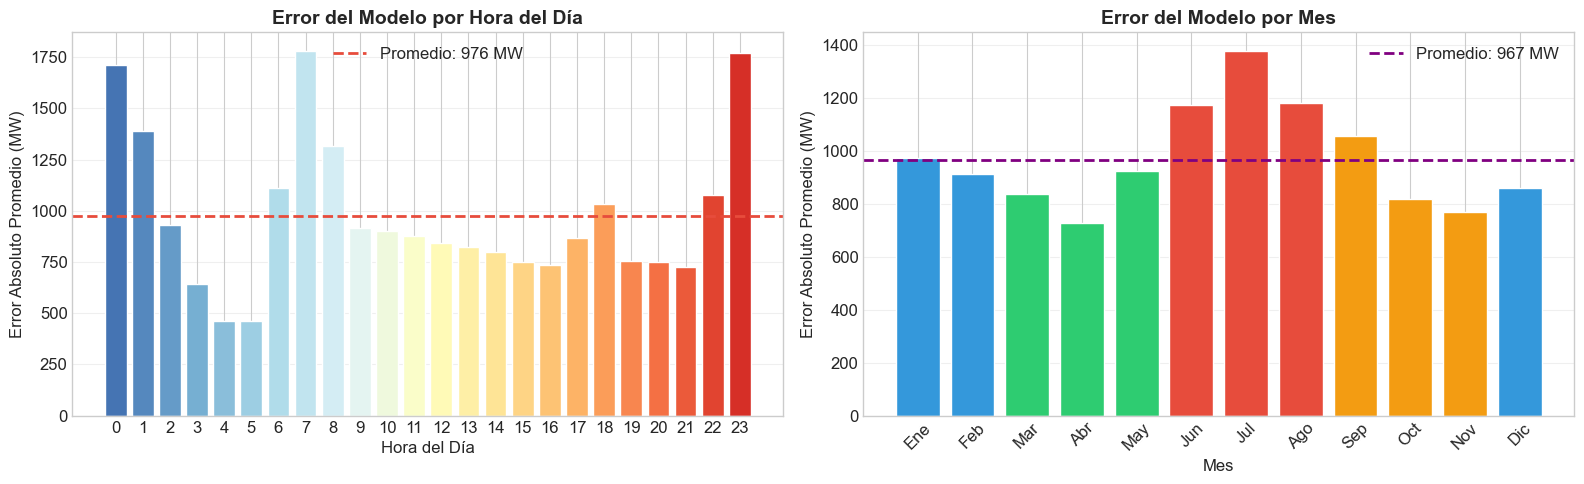

Observaciones:
   • Hora con MAYOR error: 7:00 (1,781 MW)
   • Hora con MENOR error: 5:00 (462 MW)
   • Mes con MAYOR error: Jul (1,378 MW)
   • Mes con MENOR error: Abr (726 MW)


In [83]:
# Error promedio por hora del día
error_por_hora = resultados.groupby('hour')['Error_Abs'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Error por hora
colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, 24))
axes[0].bar(error_por_hora.index, error_por_hora.values, color=colors, edgecolor='white')
axes[0].axhline(y=error_por_hora.mean(), color='#e74c3c', linestyle='--', linewidth=2,
                label=f'Promedio: {error_por_hora.mean():,.0f} MW')
axes[0].set_xlabel('Hora del Día')
axes[0].set_ylabel('Error Absoluto Promedio (MW)')
axes[0].set_title('Error del Modelo por Hora del Día', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(0, 24))
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Error por mes
error_por_mes = resultados.groupby('month')['Error_Abs'].mean()
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
season_colors = ['#3498db', '#3498db', '#2ecc71', '#2ecc71', '#2ecc71', '#e74c3c',
                 '#e74c3c', '#e74c3c', '#f39c12', '#f39c12', '#f39c12', '#3498db']

axes[1].bar(month_names, error_por_mes.values, color=season_colors, edgecolor='white')
axes[1].axhline(y=error_por_mes.mean(), color='purple', linestyle='--', linewidth=2,
                label=f'Promedio: {error_por_mes.mean():,.0f} MW')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Error Absoluto Promedio (MW)')
axes[1].set_title('Error del Modelo por Mes', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Observaciones:")
hora_max_error = error_por_hora.idxmax()
hora_min_error = error_por_hora.idxmin()
mes_max_error = month_names[error_por_mes.idxmax()-1]
mes_min_error = month_names[error_por_mes.idxmin()-1]

print(f"   • Hora con MAYOR error: {hora_max_error}:00 ({error_por_hora.max():,.0f} MW)")
print(f"   • Hora con MENOR error: {hora_min_error}:00 ({error_por_hora.min():,.0f} MW)")
print(f"   • Mes con MAYOR error: {mes_max_error} ({error_por_mes.max():,.0f} MW)")
print(f"   • Mes con MENOR error: {mes_min_error} ({error_por_mes.min():,.0f} MW)")